# MicroMass feature selection

For the original source of this data, see https://doi.org/10.24432/C5T61S

This example dataset comes from the MicroMass dataset published at UCI Machine Learning Repositiory. <br> The data used here is the Mass Spectrometry data (MALDI-TOF) of a reference panel of 20 Gram positive and negative bacterial species. The samples are clustered per species, with each instance of a species as a replicate. The data is the filtered output from 'feature_filtering.ipynb'. <br> The Gram types of the species are used as phenotypes.

## Loading the MetabolitePhenotypeFeatureSelection class and data

We start by importing the MetabolitePhenotypeFeatureSelection class. For the different import options and more info on this class, see feature_selection_manual.ipynb in the manuals folder.

In [1]:
import numpy as np

import sys
sys.path.append('../../src/phloemfinder/')

from feature_selection_using_ml import MetabolitePhenotypeFeatureSelection 

/Users/lissydenkers/miniconda3/envs/sklearn/lib/python3.9/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


Now load the datasets into an object of this class. Here, we call it 'micromass'.

In [2]:
micromass = MetabolitePhenotypeFeatureSelection(
    metabolome_csv="./filtered_features.csv",    
    phenotype_csv="./phenotype.csv",
    phenotype_sample_id='sample_id')

In [3]:
micromass.validate_input_metabolome_df()
micromass.validate_input_phenotype_df()

Metabolome data validated.
Phenotype data validated.


## Machine Learning

First we have a look at the performance of a simple Random Forest model as a baseline:

In [4]:
micromass.get_baseline_performance(
    train_size=0.7,
    random_state=123)

====== Training a basic Random Forest model =======
Average balanced_accuracy score on training data is: 97.200 % -/+ 2.00


====== Performance on test data of the basic Random Forest model =======
Average balanced_accuracy score on test data is: 99.100 %


We can see that the Random Forest already performs well with a 97.2% accuracy on the training data and a 99.1% accuracy when predicting the phenotypes of the test data.

Let's see what happens if we run Auto Machine Learning for an hour to build a good fitting pipeline.

In [5]:
micromass.search_best_model_with_tpot_and_compute_pc_importances(
    class_of_interest='positive',
    max_time_mins=60,
    max_eval_time_mins=12,
    random_state=123,
    export_best_pipeline=True,
    path_for_saving_pipeline="./best_fitting_pipeline.py")

Version 0.12.0 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.


                                                                                    
108.22 minutes have elapsed. TPOT will close down.                                  
TPOT closed during evaluation in one generation.
                                                                                    
                                                                                    
TPOT closed prematurely. Will use the current best pipeline.
                                                                                    
Best pipeline: GradientBoostingClassifier(input_matrix, learning_rate=1.0, max_depth=9, max_features=0.65, min_samples_leaf=4, min_samples_split=4, n_estimators=1000, subsample=1.0)
============ Performance of ML model on train data =============
Train balanced_accuracy score 100.000 %


============ Performance of ML model on test data =============
                   value
balanced_accuracy  0.935
precision          0.814
recall             0.972
f1 score    

The resulting best fitting pipeline has a balanced accuracy score of 100% on the training data and 93.5% on the test data. The model is slightly overfitted on the training data. Running the function for longer (for example 12 hours) will likely result in a less overfitted model. Further we can see that the recall is higher than the precision, meaning that the model is more prone to make a false negative prediction than a false positive prediction.

The output also shows that the resulting pipeline is a GradientBoostingClassifier. The pipeline was saved to "./best_fitting_pipeline.py", so it can be reused in the future.
 To see the pipeline in a neater output, we'll run:

In [6]:
micromass.best_model

Pipeline(steps=[('gradientboostingclassifier',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=9,
                                            max_features=0.65,
                                            min_samples_leaf=4,
                                            min_samples_split=4,
                                            n_estimators=1000,
                                            random_state=123))])

## Selecting the most important features

Now that we have a pipeline that can classify the samples with sufficient accuracy, we can retrieve the features that are most important for the classification. The first step is to find the most important Principal Components:

In [7]:
print(micromass.pc_importances)

       mean_var_imp  std_var_imp     perm0     perm1     perm2     perm3  \
pc                                                                         
PC0        0.441780     0.020642  0.432219  0.456299  0.470584  0.427930   
PC12       0.045468     0.010738  0.065046  0.038264  0.052448  0.031543   
PC375      0.000000     0.000000  0.000000  0.000000  0.000000  0.000000   
PC377      0.000000     0.000000  0.000000  0.000000  0.000000  0.000000   
PC378      0.000000     0.000000  0.000000  0.000000  0.000000  0.000000   
...             ...          ...       ...       ...       ...       ...   
PC185      0.000000     0.000000  0.000000  0.000000  0.000000  0.000000   
PC184      0.000000     0.000000  0.000000  0.000000  0.000000  0.000000   
PC183      0.000000     0.000000  0.000000  0.000000  0.000000  0.000000   
PC182      0.000000     0.000000  0.000000  0.000000  0.000000  0.000000   
PC570      0.000000     0.000000  0.000000  0.000000  0.000000  0.000000   

          p

There are only two important PCs for the classification with this pipeline: PC0 and PC12. With that information, we can select the features from these PCs. 

As explained in the manual, we have to be careful here with the names of the PCs. To get the 15 most important features of PC0, we should specify selected_pc=1:

In [8]:
micromass.get_names_of_top_n_features_from_selected_pc(
    selected_pc=1,
    top_n=15)

Here are the metabolite names with the top 15 absolute loadings on PC1


,feature_name,loading
0,feature_347,0.518921
1,feature_1129,0.400993
2,feature_326,0.300768
3,feature_1080,0.298268
4,feature_1181,0.264018
5,feature_1261,0.260011
6,feature_1163,0.207906
7,feature_1002,0.153934
8,feature_579,0.130685
9,feature_128,0.129151


The higher the loading of these features, the more important they are for the selected PC.

Likewise, we can get the 15 most important features for PC 12 by running:

In [9]:
micromass.get_names_of_top_n_features_from_selected_pc(
    selected_pc=13,
    top_n=15)

Here are the metabolite names with the top 15 absolute loadings on PC13


,feature_name,loading
0,feature_70,0.337480
1,feature_1163,0.315914
2,feature_243,0.272666
3,feature_418,0.251968
4,feature_643,0.251227
5,feature_538,0.220616
6,feature_471,0.218184
7,feature_399,0.215889
8,feature_446,0.201884
9,feature_1010,0.170886


Now you can make your own selection of features of interest.

An example of how to continue is making boxplots of the most important features.

In [10]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt 

In [11]:
df = pd.DataFrame
df = micromass.metabolome.T
df['gram_type'] = micromass.phenotype['phenotype']
df = df.T
df.columns = micromass.metabolome.columns.str.split("_",expand=True).get_level_values(0)
df = df.T
df['species'] = df.index

The top 3 features from PC0:

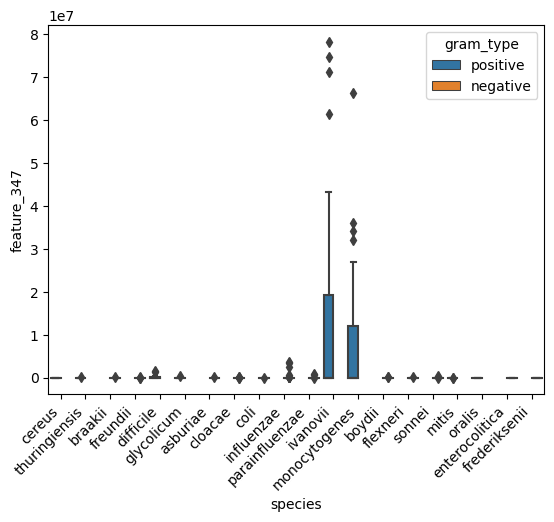

In [12]:
ax = sns.boxplot(data=df, x='species', y="feature_347", hue="gram_type")
ax.set_xticklabels(ax.get_xticklabels(),rotation=45, horizontalalignment='right')
None

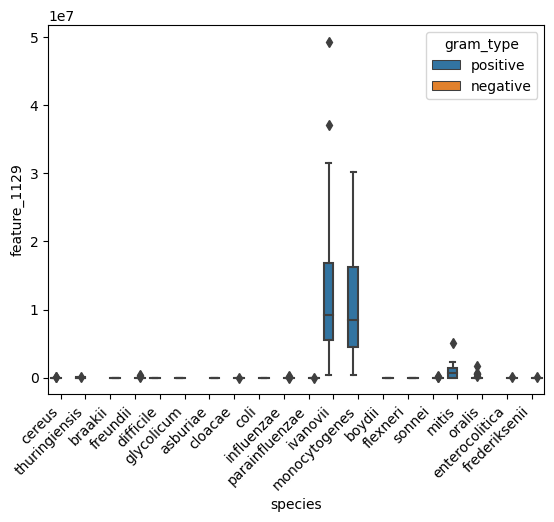

In [13]:
ax = sns.boxplot(data=df, x='species', y="feature_1129", hue="gram_type")
ax.set_xticklabels(ax.get_xticklabels(),rotation=45, horizontalalignment='right')
None

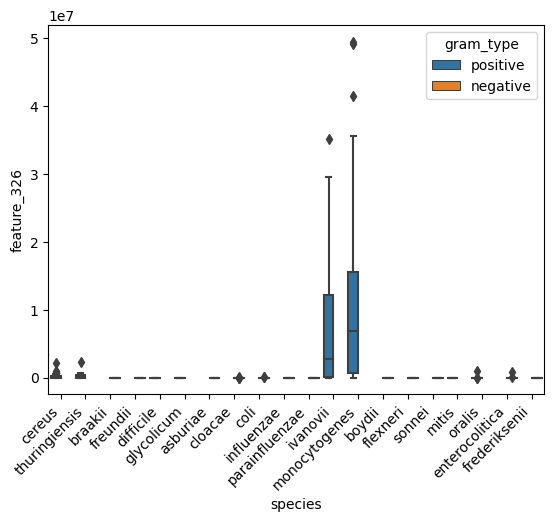

In [14]:
ax = sns.boxplot(data=df, x='species', y="feature_326", hue="gram_type")
ax.set_xticklabels(ax.get_xticklabels(),rotation=45, horizontalalignment='right')
None

And the top 3 features of PC12:

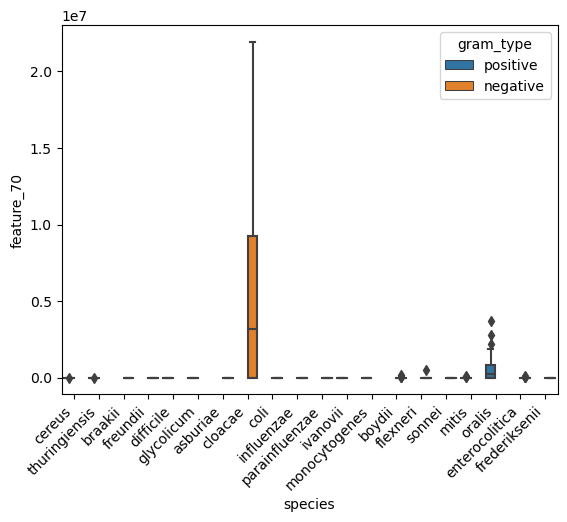

In [15]:
ax = sns.boxplot(data=df, x='species', y="feature_70", hue="gram_type")
ax.set_xticklabels(ax.get_xticklabels(),rotation=45, horizontalalignment='right')
None

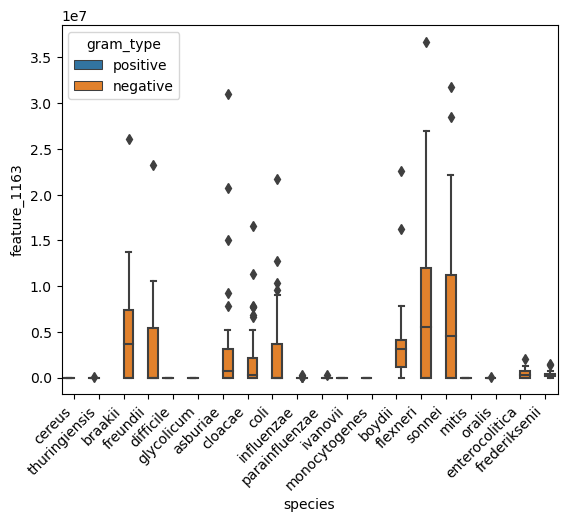

In [16]:
ax = sns.boxplot(data=df, x='species', y="feature_1163", hue="gram_type")
ax.set_xticklabels(ax.get_xticklabels(),rotation=45, horizontalalignment='right')
None

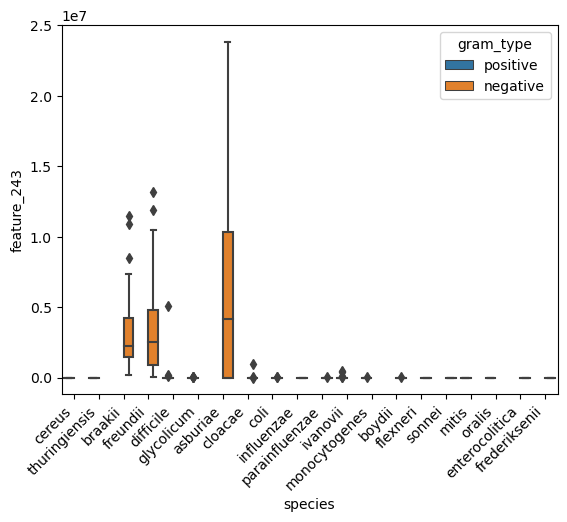

In [17]:
ax = sns.boxplot(data=df, x='species', y="feature_243", hue="gram_type")
ax.set_xticklabels(ax.get_xticklabels(),rotation=45, horizontalalignment='right')
None

Based on these plots, feature 1163 might be interesting to annotate and analyse in more detail if you want to find out more about the differences between Gram positive and negative bacteria.